## Comparing, Reconciling, and Combining COVID-19 Data Sources

### Summary

In this note we use `gs-quant` to compare COVID-19 data sources. To do this, we first retrieve COVID-19-related time 
series data and preprocess it, joining different sources together to analyze confirmed cases. 

The contents of this notebook are as follows:

- [1 - Getting Started](#1---Getting-Started)
- [2 - COVID-19 Data](#2---COVID-19-Data)
- [3 - Comparing Global Sources](#3---Comparing-Global-Sources)
- [4 - Comparing US Sources](#4---Comparing-US-Sources)
- [5 - Comparing subregions, combining with mobility data](#5---Comparing-subregions,-combining-with-mobility-data)

### 1 - Getting Started

Start every session with authenticating with your unique client id and secret. For information on
how to get setup on GS Quant, see [Getting Started](/covid/guides/getting-started). Below produced
using gs-quant version 0.8.126

In [38]:

from gs_quant.session import GsSession, Environment

GsSession.use(client_id= '01bd1e5bdb1247d29dbe0c0db29b800b', client_secret='3d53384141b6a4d9b3e897d8d1df1732bf49af5faeeb13b024dc9227538bf588', scopes=('read_product_data',))




### 2 - COVID-19 Data

We'll start by defining a general function to load various datasets, which includes regional data,
since December 31 2019:

In [145]:
from gs_quant.data import Dataset
import datetime

def get_datasets(datasets):
    ds_dict = {}
    for dataset in datasets:
        try:
            df = Dataset(dataset).get_data(datetime.date(2019, 6, 23), datetime.datetime.today().date())
            
            keys = [x for x in ['countryId', 'subdivisionId'] if x in df.columns] + ['date']
            val_map = {'newConfirmed': 'totalConfirmed', 'newFatalities': 'totalFatalities'}
            vals = [x for x in list(val_map.keys()) if x in df.columns]

            df_t = df.groupby(keys).sum().groupby(level=0).cumsum().reset_index()[keys + vals].rename(columns=val_map)
            ds_dict[dataset] = df.reset_index().merge(df_t, on=keys, suffixes=('', '_y')).set_index('date')

        except Exception as err:
            print(f'Failed to obtain {dataset} with {getattr(err,"message",repr(err))}')
    return ds_dict

We create a list of some of the available datasets, and fetch all of them, so that we can compare them.

In [146]:
country_datasets = ['COVID19_US_DAILY_CDC']
df = get_datasets(country_datasets)

Next we look at the date ranges of each dataset to determine how much history they have, and ensure they are 
up-to-date:

In [148]:
for name, ds in df.items():
    print('{:<30}  {}  {}'.format(name, ds.index[0].date(), ds.index[-1].date())) 

COVID19_US_DAILY_CDC            2020-01-22  2020-07-23


### 3 - Comparing Global Sources

Below is a general function to compare the time series of certain columns across datasets:

In [149]:
import re
from typing import Union

def compare_time_series(df, datasets, columns: Union[str, list], grouping: str = 'countryId', suffix_identifier: float = 1):
    columns = [columns] if isinstance(columns, str) else columns
    suffixes = list(map(lambda ds_name: '_' + re.findall('\_([A-Z]+)', ds_name)[-suffix_identifier], datasets))
    df_combo = None

    for ds_name in datasets:
        ds = df[ds_name]
        df_combo = ds if df_combo is None else df_combo
        df_suffixes = ('', '_' + re.findall('\_([A-Z]+)', ds_name)[-suffix_identifier])
        df_combo = df_combo.merge(ds, on=['date', grouping], suffixes=df_suffixes)

    return df_combo[[grouping] + [column + suffix for suffix in suffixes for column in columns]]

For example, if we want to compare the time series for total confirmed cases across the WHO, ECDC, and Wikipedia 
datasets globally, we can do the following:

In [150]:
datasets = ['COVID19_US_DAILY_CDC'] 
df_to_compare = compare_time_series(df, datasets, columns='totalConfirmed')

df_to_compare.describe().style.background_gradient(cmap='Blues',axis=1).format('{:,.2f}')

,totalConfirmed_CDC
count,184.00
mean,"1,122,061.35"
std,"1,163,245.64"
min,1.00
25%,385.25
50%,"847,013.00"
75%,"1,943,222.50"
max,"4,024,492.00"


This shows statistical properties for each dataset for all common countries and dates. As we can see, there's some 
variation in the data sources. Let's dig in a little further and plot the relationship between the WHO and ECDC for 
a number of countries: 

In [151]:
import seaborn as sns


As we can see, there is some dispersion between sources for certain countries. For information on the various ISO
country codes, see [this guide](https://developer.gs.com/docs/covid/guides/standards/iso-countries/).

### 4 - Comparing US Sources

Now let's take a closer look at the US data, adding in the CDC dataset:

In [152]:
datasets = ['COVID19_US_DAILY_CDC'] 
df_to_compare = compare_time_series(df, datasets, columns='totalConfirmed')

df_to_compare.describe().style.background_gradient(cmap='Blues',axis=1).format('{:,.2f}')

,totalConfirmed_CDC
count,184.00
mean,"1,122,061.35"
std,"1,163,245.64"
min,1.00
25%,385.25
50%,"847,013.00"
75%,"1,943,222.50"
max,"4,024,492.00"


As of 21 of May 2020, CDC had the most confirmed cases, followed by Wikipedia, and then ECDC and WHO. This is not 
overly surprising given the information collection and validation flows. Now let's examine the last few points:

Now let's compare all the series side by side:

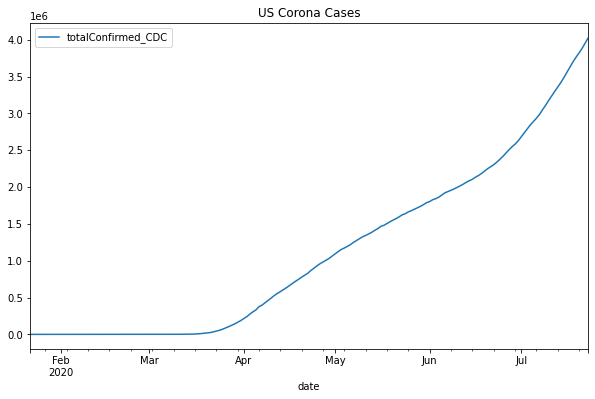

In [153]:
df_to_compare.plot(figsize=(10, 6), title='US Corona Cases');

In [54]:
import matplotlib.pyplot as plt


This chart illustrates how the ECDC and CDC map cases versus the WHO. At the start of the epidemic these sources were
much closer, and diverged over time, with CDC leading in reporting for the US versus the ECDC and WHO. 

# Deep Learning Ananlysis

In this section we will examing the "COVID19_US_DAILY_CDC" dataset in order to try and construct a multivariate time series predictive model using Recurrent Neural Networks in Tensor Flow.

We'll start by importing the necessary packages 

In [154]:
#Set up for the Recurral Neural Network to predict future cases in the US
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

Then, we will glance at the data  of the US cases over time

In [155]:
country_datasets = ['COVID19_US_DAILY_CDC']
df = get_datasets(country_datasets)
us_dataframe = df['COVID19_US_DAILY_CDC']

us_CaseNumbers = us_dataframe.loc[:,'totalConfirmed'].values #numpy array of case numbers

us_dataframe.head()



,countryId,totalConfirmed,totalByOnset,updateTime
date,,,,
2020-01-22,US,1.0,3.0,2020-07-24 18:38:01.164
2020-01-23,US,1.0,1.0,2020-07-24 18:38:01.164
2020-01-24,US,2.0,5.0,2020-07-24 18:38:01.164
2020-01-25,US,2.0,5.0,2020-07-24 18:38:01.164
2020-01-26,US,5.0,1.0,2020-07-24 18:38:01.164


We'll then show how total confirmed cases data looks over time

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f1e238fceb8>],
      dtype=object)

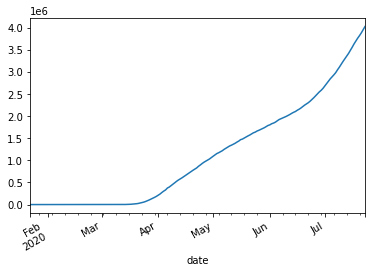

In [156]:
#df_to_compare.plot(figsize=(10, 6), title='US Corona Cases');
us_dataframe['totalConfirmed'].plot(subplots=True)

Now we will start the DL process in which we will then predict the cases at a particular window of time


In [157]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

The first 150 rows of the data will be the training dataset, and there remaining will be the validation dataset. This means there will be around 5 months worth of training data.

In [177]:
TRAIN_SPLIT = 60

Setting seed for reproducability

In [178]:
tf.random.set_seed(1)

Standardizing the data

In [179]:
caseNumbers = us_dataframe.loc[:,'totalConfirmed'].values #numpy array of case numbers
caseNumbers_mean = caseNumbers[:TRAIN_SPLIT].mean()
caseNumbers_std = caseNumbers[:TRAIN_SPLIT].std()
caseNumbers = (caseNumbers-caseNumbers_mean)/caseNumbers_std


Now in the framework of a univariate model,the model will be given the last 5 case number readings, and needs to learn to predict the case numbers at the next time reading (next month)

In [193]:
univariate_past_history = 10
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(caseNumbers, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(caseNumbers, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

What the univariate function returns:

In [194]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target case number to predict')
print (y_train_uni[0])

Single window of past history
[[-0.34408476]
 [-0.34408476]
 [-0.34386503]
 [-0.34386503]
 [-0.34320583]
 [-0.34320583]
 [-0.34320583]
 [-0.34320583]
 [-0.34320583]
 [-0.34276637]]

 Target case number to predict
-0.34254663963956195


Now that the data has been created, let's take a look at a single example. The information given to the network is given in blue, and it must predict the value at the red cross

In [195]:
def create_time_steps(length):
  return list(range(-length, 0))

In [196]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

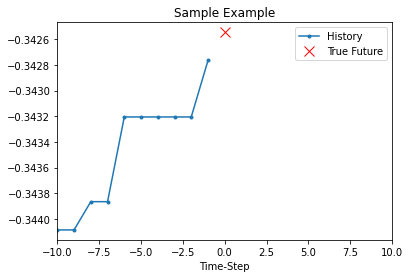

In [197]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

Before proceeding to train a model, let's first set a simple baseline. Given an input point, the baseline method looks at all the history and predicts the next point to be the average of the last 5 observations.

In [198]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py'>

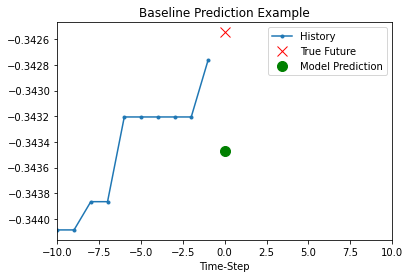

In [199]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

As you can see the above diagram is clearly wrong why it is necessary to train the model, our aim is to now beat the baseline and improve upon our model using RNNs

# Utilizing the Recurrent Neural Network

A Recurrent Neural Network (RNN) is a type of neural network well-suited to time series data. RNNs process a time series step-by-step, maintaining an internal state summarizing the information they've seen so far.

In [200]:
BATCH_SIZE = 5
BUFFER_SIZE = 60
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

We will then use the LSTM model which is a NN architecture that uses feedback loops which enables us to better predict continuous time based data

In [201]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

In [209]:
EVALUATION_INTERVAL = 50
EPOCHS = 20

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps= 20)

Epoch 1/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0210 - val_loss: 337.5996
Epoch 2/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0207 - val_loss: 337.6000
Epoch 3/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0210 - val_loss: 337.5976
Epoch 4/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0212 - val_loss: 337.5831
Epoch 5/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0207 - val_loss: 337.5577
Epoch 6/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0213 - val_loss: 337.6076
Epoch 7/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0204 - val_loss: 337.5512
Epoch 8/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0209 - val_loss: 337.5387
Epoch 9/20
50/50 [==============================] - 0s 6ms/step - loss: 0.0204 - val_loss: 337.6074
Epoch 10/20
50/50 [==============================] - 0s 5ms/step - loss: 0.0217 - val_loss: 337.6011

Now that the model is trained lets attempt to make a prediction

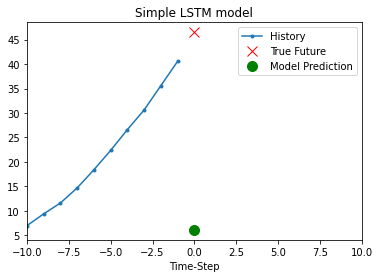

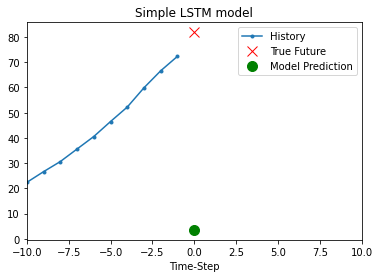

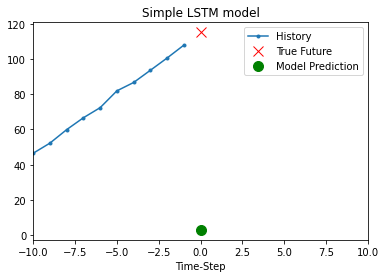

In [210]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

### 5 - Comparing subregions, combining with mobility data

Finally, we illustrate how to compare datasets for specific countries (in this case, Italy) at different level of granularity (region, province, etc.) and how to ccombine epidemic data with mobility data from Google.

As before, we fetch data for Italy, at three levels of granularity.

In [20]:
datasets = ['COVID19_ITALY_DAILY_DPC', 'COVID19_REGION_DAILY_DPC', 'COVID19_PROVINCE_DAILY_DPC'] 
df = get_datasets(datasets)

Failed to obtain COVID19_ITALY_DAILY_DPC with {"statusCode":403,"reasonPhrase":"Forbidden","title":"Error","messages":["Not authorized to query resource: DataSet IDs COVID19_ITALY_DAILY_DPC","Request: 1cf8c8d8-6226076"]}
Failed to obtain COVID19_REGION_DAILY_DPC with {"statusCode":403,"reasonPhrase":"Forbidden","title":"Error","messages":["Not authorized to query resource: DataSet IDs COVID19_REGION_DAILY_DPC","Request: 9f276e96-6298122"]}
Failed to obtain COVID19_PROVINCE_DAILY_DPC with {"statusCode":403,"reasonPhrase":"Forbidden","title":"Error","messages":["Not authorized to query resource: DataSet IDs COVID19_PROVINCE_DAILY_DPC","Request: 8b32e3af-6298698"]}


In [ ]:
df_to_compare = compare_time_series(df, datasets, columns='totalConfirmed', suffix_identifier=3)

df_to_compare.describe().style.background_gradient(cmap='Blues',axis=1).format('{:,.2f}')

We write a function to compare the data across different geographic subdivisions.

In [ ]:
from functools import reduce
import pandas as pd

def compare_totals_across_breakdowns(df, data1, data2, column_to_check):
    
    # pick the common indices between the data being compared
    common_idx_province = reduce(lambda x, y:  x & y, 
                            df[data1[0]].groupby(data1[1]).apply(lambda x: x.index).tolist())
    common_idx_region = reduce(lambda x, y:  x & y, 
                            df[data2[0]].groupby(data2[1]).apply(lambda x: x.index).tolist())
    idx = common_idx_province & common_idx_region
    
    # calculate the difference, and rename column
    diff = df[data1[0]].groupby(data1[1]).apply(lambda x : x.loc[idx][column_to_check]).T.apply(sum,axis=1) -\
           df[data2[0]].groupby(data2[1]).apply(lambda x : x.loc[idx][column_to_check]).T.apply(sum,axis=1)
    diff = pd.DataFrame(diff).rename(columns={0:f'{data1[0]}-{data2[0]}'})
    return diff

diff1 = compare_totals_across_breakdowns(df, ('COVID19_ITALY_DAILY_DPC','countryId'),
                                         ('COVID19_REGION_DAILY_DPC','subdivisionId'),'totalConfirmed')
diff2 = compare_totals_across_breakdowns(df, ('COVID19_REGION_DAILY_DPC','subdivisionId'),
                                        ('COVID19_PROVINCE_DAILY_DPC','administrativeRegion'),'totalConfirmed')

We plot the discrepancies below...

In [ ]:
to_plot = diff1.join(diff2)

sns.lmplot(x="COVID19_ITALY_DAILY_DPC-COVID19_REGION_DAILY_DPC", y="COVID19_REGION_DAILY_DPC-COVID19_PROVINCE_DAILY_DPC",
          data=to_plot);

... and interestingly, this indicates there is no discrepancy at all when we compare country-level aggregate data with region-level aggregate data, but we do see discrepancies when we compate province-level with region-level data.

Finally, we illustrate how to join region-level data from Italy with mobility data from Google, which allows us to check, for example, how the increase in cases of COVID-19 affected mobility patterns in the population. 

In [ ]:
from datetime import datetime

df_mob = Dataset('COVID19_SUBDIVISION_DAILY_GOOGLE').get_data(start_date=datetime(2020,2,1).date(), countryId='IT')

In [ ]:
df_mob.head(2)

We now join mobility data with region-level data in Italy, for the subdivision of Liguria.

In [ ]:
def join_dfs(subdivision, mobility, column_to_compare):
    df_red = df['COVID19_REGION_DAILY_DPC'][df['COVID19_REGION_DAILY_DPC']['subdivisionId'] == subdivision]
    subdivision_name = df_red['subdivisionName'].unique()[0]
    df1 = df_red[[column_to_compare]]
    df2 = df_mob[df_mob.subdivisionId.isin([subdivision]) & df_mob.group.isin([mobility])]
    df_joint = df1.merge(df2, on='date')
    return df_joint, mobility, subdivision_name

df_joint, mobility, subdivision_name = join_dfs('IT-42', 'retailRecreation', 'newConfirmed')

Finally, we plot a chart comparing mobility data with data on the growth of the epidemic.

In [ ]:
df_joint['Change in Mobility'] = df_joint['value'].diff()
df_joint[['newConfirmed','value']].rename(columns={'newConfirmed':'New Confirmed Cases',
                                                   'value':f'Change in {mobility} mobility'}).plot(figsize=(10,7,), grid=True,
            title=f'Comparison of new confirmed cases and mobility in {subdivision_name}');

We can observe a dramatic drop in moblity as the rate of new cases began to increase, a pattern that persisted during the peak of the epidemic in the region of Liguria.

Please reach out to `covid-data@gs.com` with any questions.

### Disclaimer
This website may contain links to websites and the content of third parties ("Third Party Content"). We do not monitor, 
review or update, and do not have any control over, any Third Party Content or third party websites. We make no 
representation, warranty or guarantee as to the accuracy, completeness, timeliness or reliability of any 
Third Party Content and are not responsible for any loss or damage of any sort resulting from the use of, or for any 
failure of, products or services provided at or from a third party resource. If you use these links and the 
Third Party Content, you acknowledge that you are doing so entirely at your own risk.